# Saliencies for CondVAE model

Look at saliencies to understand what channels the model is focussing on.

Could also look at neighborhood models and their differences with this.

In [85]:
from campa.constants import campa_config
from campa.tl import Experiment, Predictor, Cluster
from campa.data import MPPData
import os
from campa.tl._cluster import annotate_clustering
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
pred = Predictor(exp)

2022-10-24 16:32:07.331019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
exp.full_path

'/Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/CondVAE_pert-CC'

In [27]:
mpp_data = MPPData.from_data_dir('aggregated/sub-0.001', data_config='NascentRNA', base_dir=exp.full_path, keys=['latent', 'conditions', 'clustering_res0.5'])
cluster_annotation = pd.read_csv(os.path.join(exp.full_path, 'aggregated/sub-0.001/clustering_res0.5_annotation.csv'), index_col=0)

In [33]:
# add annotation of clustering to mpp_data
mpp_data._data['annotation'] = annotate_clustering(list(map(int, mpp_data.data('clustering_res0.5'))), annotation=cluster_annotation, cluster_name='clustering_res0.5', annotation_col='annotation')

In [130]:
def interpolate_mpps(baseline,mpp,alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(mpp, axis=0)
    delta = input_x - baseline_x
    mpps = baseline_x +  alphas_x * delta
    return mpps

def compute_gradients(pred, mpps, condition):
    with tf.GradientTape() as tape:
        tape.watch(mpps)
        logits = pred.est.model.encoder((mpps, tf.tile(condition, [len(mpps),1])))
    return tape.gradient(logits, mpps)

def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

def integrated_gradients(pred, mpp, condition, m_steps=50):
    baseline = tf.zeros_like(mpp)
    # Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # Get Gradients
    interpolated_mpps = interpolate_mpps(baseline, mpp, alphas)
    gradients = compute_gradients(pred, interpolated_mpps, condition)
    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (mpp - baseline) * avg_gradients

    return integrated_gradients


# calculate gradients for n samples
grads = []
annotation = []
for i in range(10000):
    mpp = tf.convert_to_tensor(mpp_data.mpp[i])
    cond = tf.expand_dims(tf.convert_to_tensor(mpp_data.conditions[i]), axis=0)
    grads.append(integrated_gradients(pred, mpp, cond).numpy())
    annotation.append(mpp_data._data['annotation'][i])
grads = np.array(grads)
annotation = np.array(annotation)
    

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00, 8.50000e+01,
        6.50200e+03, 3.19241e+05, 1.41050e+04, 6.00000e+01, 2.00000e+00]),
 array([-0.01932704, -0.01638249, -0.01343795, -0.0104934 , -0.00754885,
        -0.00460431, -0.00165976,  0.00128478,  0.00422933,  0.00717387,
         0.01011842], dtype=float32),
 <BarContainer object of 10 artists>)

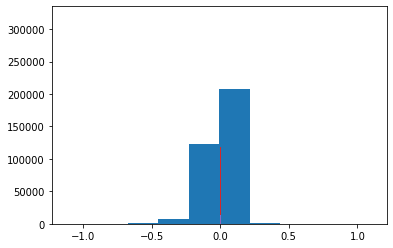

In [131]:
# evaluate and plot results
# gradients over neighborhood are really small compared to center pixel
plt.hist(grads[:,1,1].flat)
plt.hist(grads[:,0,0].flat)
plt.hist(grads[:,2,0].flat)
plt.hist(grads[:,2,2].flat)
plt.hist(grads[:,0,2].flat)

In [132]:
# todo filter by well / condition and compare grads

In [133]:
clusters = np.unique(annotation)
channels = list(mpp_data.channels.name)
mean_ig = np.zeros((len(clusters), len(channels)))
std_ig = np.zeros((len(clusters), len(channels)))

for i,cl in enumerate(clusters):
    mask = annotation == cl
    for j, ch in enumerate(channels):
        mean_ig[i,j] = grads[mask][:,:,:,j].mean()
        std_ig[i,j] = grads[mask][:,:,:,j].std()

<AxesSubplot:>

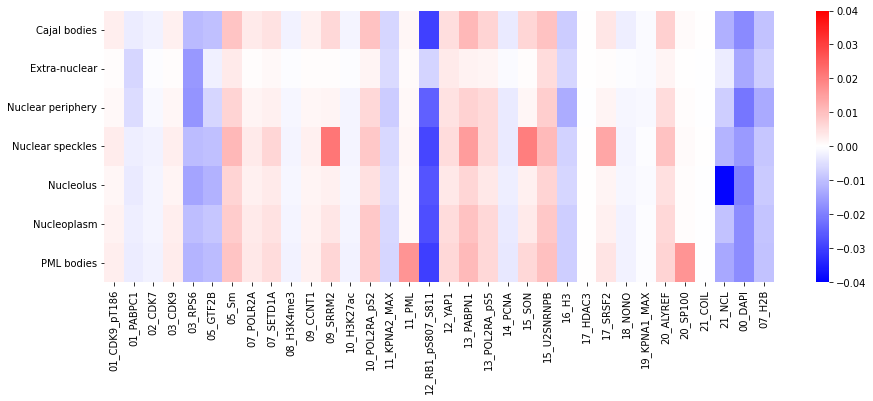

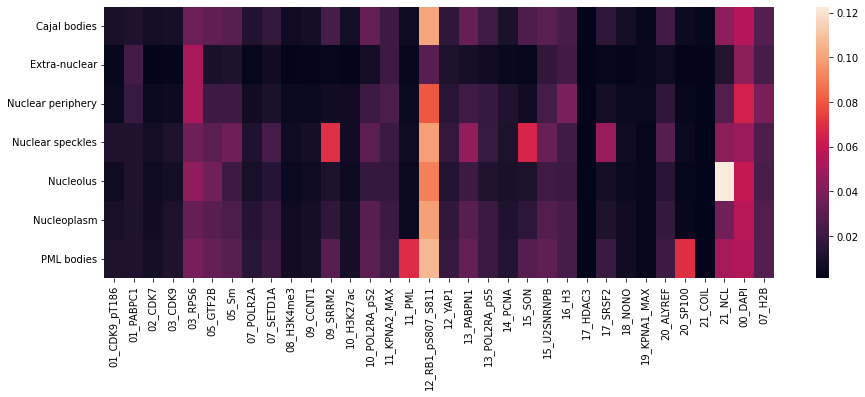

In [134]:
import seaborn as sns

# grads llok interesting. but NCL for nucleolus is negative grad? Why?? - Maybe in some condition only  - seems to have large variance

fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.heatmap(mean_ig, yticklabels=clusters, xticklabels=channels, ax=ax, cmap='bwr', vmin=-0.04, vmax=0.04)

fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.heatmap(std_ig, yticklabels=clusters, xticklabels=channels, ax=ax)

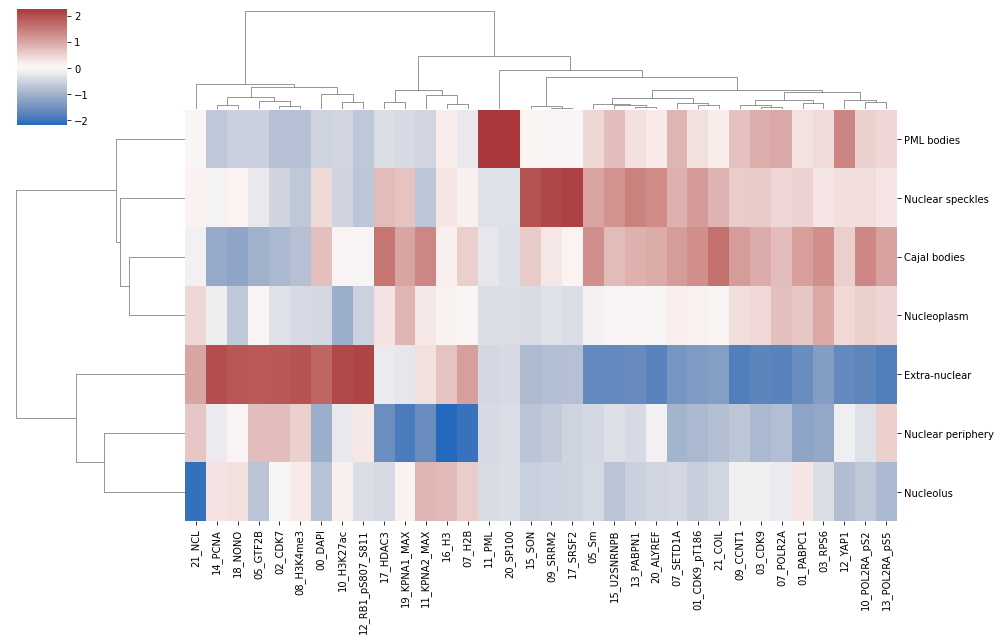

In [112]:
row_standard = sns.clustermap(mean_ig, z_score=1, cmap="vlag", figsize=[14,9], method='ward', yticklabels=clusters, xticklabels=channels)